In [2]:
#Preprocessing the dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

#For splitting the training and testing dataset
from sklearn.model_selection import train_test_split

#For Defining Layers
from keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Concatenate, Dense, ReLU, ZeroPadding2D, Activation
from keras.models import Model
from keras.initializers import RandomNormal

#for ploting the models
from keras.utils import plot_model

In [3]:
colorPath = "../input/landscape-image-colorization/landscape Images/color/"
grayPath = "../input/landscape-image-colorization/landscape Images/gray/"

In [4]:
import os

colorImgPath = []
grayImgPath = []

for imgPath in os.listdir(colorPath) :
    colorImgPath.append(os.path.join(colorPath, imgPath))
    
for imgPath in os.listdir(grayPath) :
    grayImgPath.append(os.path.join(grayPath, imgPath))

In [5]:
colorImgPath.sort()
grayImgPath.sort()

In [6]:
from PIL import Image
from tensorflow.keras.utils import img_to_array

X = []
Y = []

for i in range(5000) :
    
    img1 = cv2.cvtColor(cv2.imread(colorImgPath[i]), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(grayImgPath[i]), cv2.COLOR_BGR2RGB)
    
    Y.append(img_to_array(Image.fromarray(cv2.resize(img1,(128,128)))))
    X.append(img_to_array(Image.fromarray(cv2.resize(img2,(128,128)))))

In [7]:
X=np.array(X)
Y=np.array(Y)

print(X.min())
print(X.max())
print(Y.min())
print(Y.max())

0.0
255.0
0.0
255.0


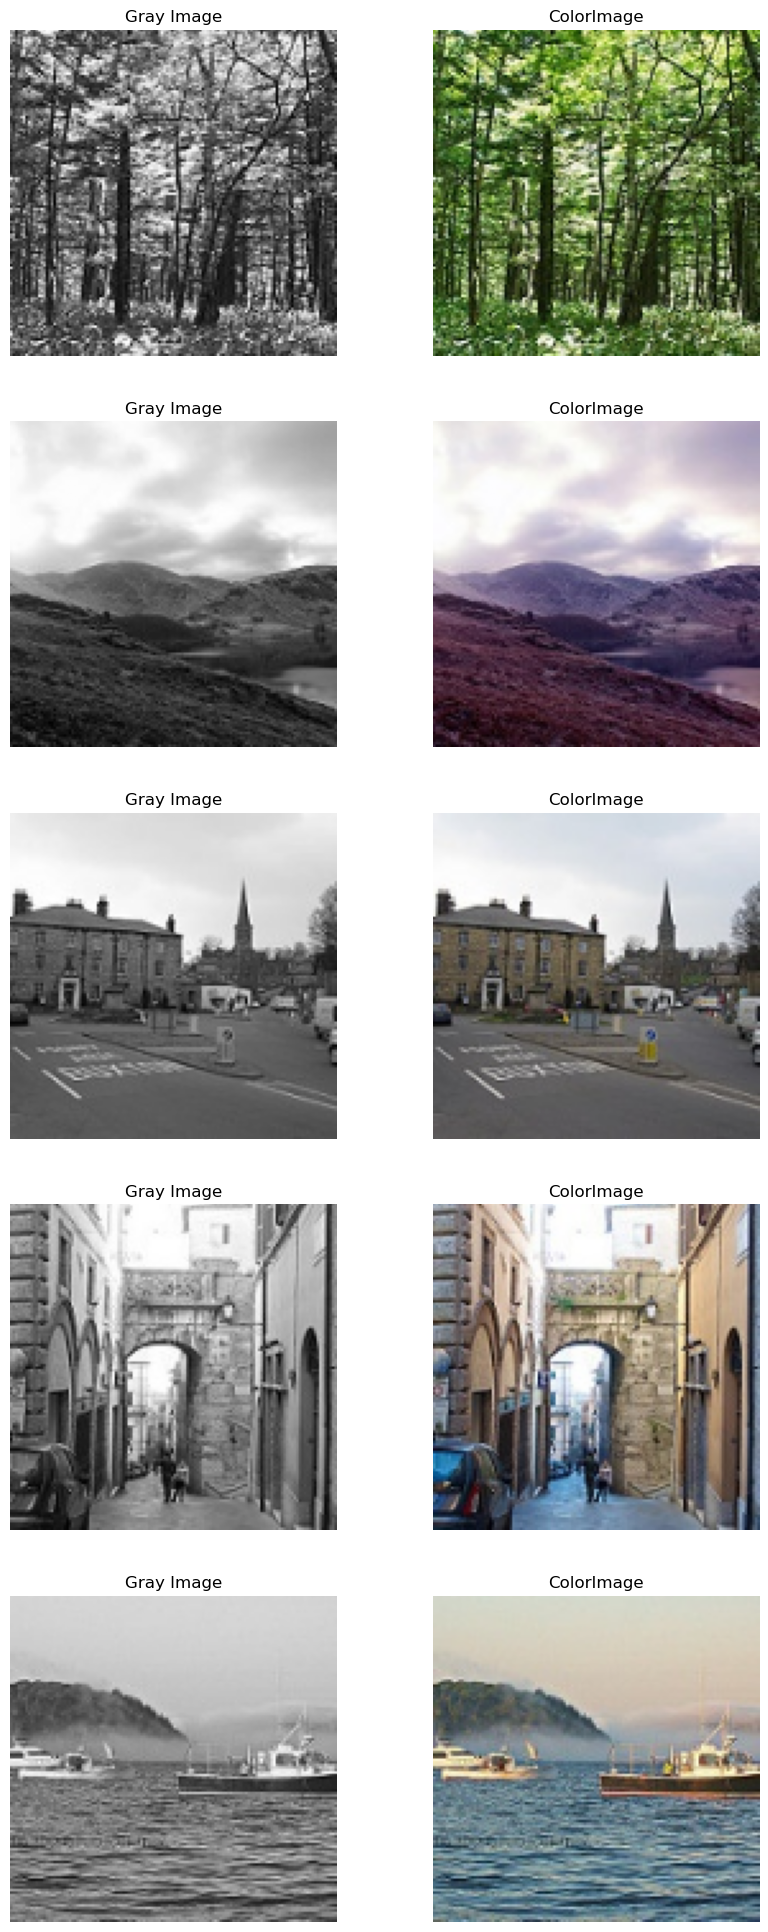

In [8]:
plt.figure(figsize = (10,50))

i = 0

while i < 10:
    
    x = np.random.randint(0,3000)
    
    plt.subplot(10, 2, i+1)
    plt.imshow(X[x]/255.0,'gray')
    plt.axis('off')
    plt.title('Gray Image')
    
    plt.subplot(10, 2, i+2)
    plt.imshow(Y[x]/ 255.0)
    plt.axis('off')
    plt.title('ColorImage')
    i += 2
plt.show()

In [9]:
X=(X/127.5)-1
Y=(Y/127.5)-1

In [10]:
print(X.min())
print(X.max())
print(Y.min())
print(Y.max())

-1.0
1.0
-1.0
1.0


In [11]:
trainX, testX, trainY, testY = train_test_split(X, Y,test_size=0.15)

In [12]:
print("Train dataset shape")
print(trainX.shape)
print(trainY.shape)
print("\nTest dataset shape")
print(testX.shape)
print(testY.shape)

Train dataset shape
(4250, 128, 128, 3)
(4250, 128, 128, 3)

Test dataset shape
(750, 128, 128, 3)
(750, 128, 128, 3)


In [13]:
init=RandomNormal(mean=0.0, stddev=0.02)

In [14]:
def Discriminator(image_shape) :#Discriminator(PatchGAN)
    
    #Inputs for discriminator
    genI = Input(shape =  image_shape)
    tarI = Input(shape =  image_shape)
    conc = Concatenate()([genI, tarI])
    
    #downsampling
    c064 = Conv2D(64,(4,4),strides=2,padding='same',use_bias=False,kernel_initializer= init)(conc)
    c064 = LeakyReLU(0.2)(c064)
    
    c128 = Conv2D(128, (4,4),strides=2,padding='same',use_bias=False,kernel_initializer= init)(c064)
    c128 = BatchNormalization()(c128)
    c128 = LeakyReLU(0.2)(c128)
    
    c256 = Conv2D(256,(4,4),strides=2,padding='same',use_bias=False,kernel_initializer= init)(c128)
    c256 = BatchNormalization()(c256)
    c256 = LeakyReLU(0.2)(c256)
    
    temp = ZeroPadding2D()(c256)
    
    c512 = Conv2D(512,(4,4),strides=2,padding='valid',use_bias=False,kernel_initializer=init)(temp)
    c512 = BatchNormalization()(c512)
    c512 = LeakyReLU(0.2)(c512)
    
    temp = ZeroPadding2D()(c512)
    
    c001 = Conv2D(1,(4,4), strides=1, padding='valid',activation = 'sigmoid', kernel_initializer=init)(temp)
    
    model = Model(inputs = [genI, tarI], outputs = c001)
    
    return model

In [15]:
def generator(): #UNet model
    srcI = Input(shape=(128,128,3,))
    
    # Contracting path
    c064 = Conv2D(64,(4,4),strides=2,padding='same',use_bias=False,kernel_initializer=init)(srcI)
    c064 = LeakyReLU(0.2)(c064)
    
    c128 = Conv2D(128,(4,4),strides=2,padding='same',use_bias=False,kernel_initializer=init)(c064)
    c128 = BatchNormalization()(c128)
    c128 = LeakyReLU(0.2)(c128)
    
    c256 = Conv2D(256,(4,4),strides=2, padding='same',use_bias=False, kernel_initializer=init)(c128)
    c256 = BatchNormalization()(c256)
    c256 = LeakyReLU(0.2)(c256)
    
    c512 = Conv2D(512, (4,4),strides=2,padding='same',use_bias=False,kernel_initializer=init)(c256)
    c512 = BatchNormalization()(c512)
    c512 = LeakyReLU(0.2)(c512)
    
    d512 = Conv2D(512, (4,4),strides=2,padding='same',use_bias=False,kernel_initializer=init)(c512)
    d512 = BatchNormalization()(d512)
    d512 = LeakyReLU(0.2)(d512)
    
    e512 = Conv2D(512,(4,4),strides=2,padding='same',use_bias=False,kernel_initializer=init)(d512)
    e512 = BatchNormalization()(e512)
    e512 = LeakyReLU(0.2)(e512)
    
    # Bottleneck layer
    f512 = Conv2D(512, (4,4), strides=2, padding='same',use_bias=False, kernel_initializer=init)(e512)
    f512 = BatchNormalization()(f512)
    f512 = LeakyReLU(0.2)(f512)
    
    # Expanding  path
    u512 = Conv2DTranspose(512, (4,4),strides=2,padding='same',use_bias=False,kernel_initializer=init)(f512)
    u512 = BatchNormalization()(u512)
    u512 = ReLU()(u512)
    u512 = Concatenate()([u512,e512])
        
    u512 = Conv2DTranspose(512, (4,4), strides=2, padding='same',use_bias=False,kernel_initializer=init)(u512)
    u512 = BatchNormalization()(u512)
    u512 = ReLU()(u512)
    u512 = Concatenate()([u512,d512])
    
    u512 = Conv2DTranspose(512, (4,4), strides=2, padding='same', use_bias=False, kernel_initializer=init)(u512)
    u512 = BatchNormalization()(u512)
    u512 = ReLU()(u512)
    u512 = Concatenate()([u512,c512])
    
    u256 = Conv2DTranspose(512, (4,4), strides=2, padding='same', use_bias=False, kernel_initializer=init)(u512)
    u256 = BatchNormalization()(u256)
    u256 = ReLU()(u256)
    u256 = Concatenate()([u256,c256])
    
    u128 = Conv2DTranspose(128, (4,4), strides=2, padding='same', use_bias=False, kernel_initializer=init)(u256)
    u128 = BatchNormalization()(u128)
    u128 = ReLU()(u128)
    u128 = Concatenate()([u128,c128])
    
    u064 = Conv2DTranspose(64, (4,4), strides=2,padding='same',use_bias=False,kernel_initializer=init)(u128)
    u064 = BatchNormalization()(u064)
    u064 = ReLU()(u064)
    u064 = Concatenate()([u064,c064])
    
    genI = Conv2DTranspose(3, (4,4), strides = 2, padding = 'same', activation = 'tanh', kernel_initializer = init)(u064)

    model = Model(inputs = srcI, outputs = genI)
    
    return model

In [16]:
exampleDiscriminator = Discriminator((128,128,3,))
exampleDiscriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [17]:
exampleGenerator = generator()
exampleGenerator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 64, 64, 64)   3072        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 64, 64, 64)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 128)  131072      ['leaky_re_lu_4[0][0]']    

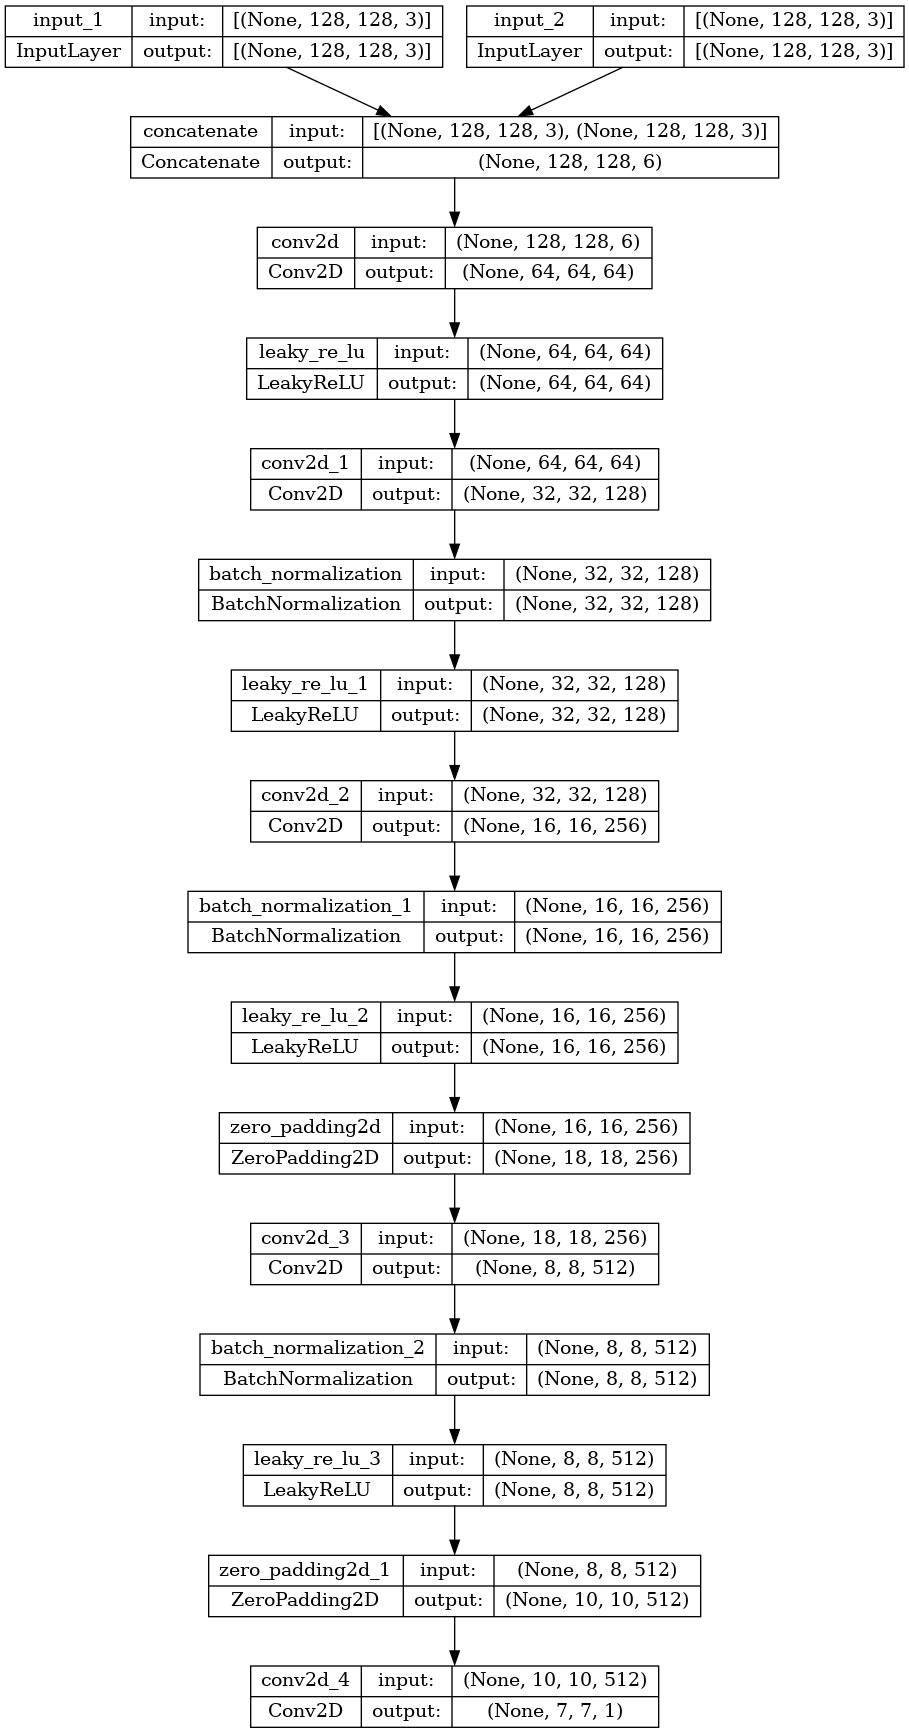

In [18]:
plot_model(exampleDiscriminator, './discriminatorModel.png',show_shapes=True)

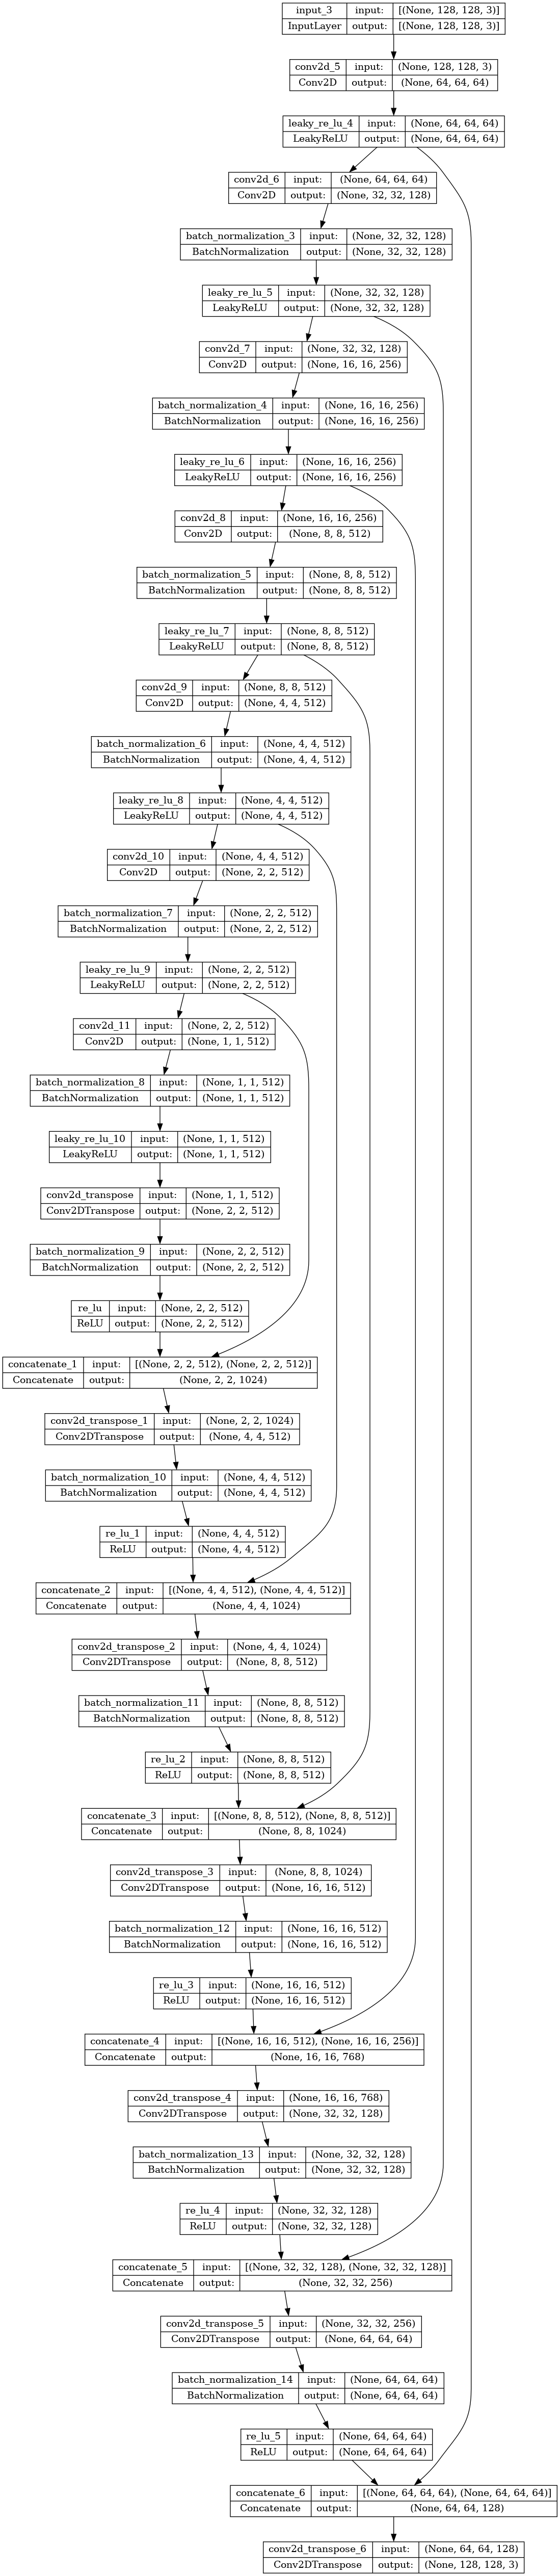

In [19]:
plot_model(exampleGenerator, './generatorModel.png', show_shapes=True)

In [20]:
Lambda=100
batchSize=16
bufferSize=400

In [21]:
trainDataset=tf.data.Dataset.from_tensor_slices((trainX,trainY))
testDataset=tf.data.Dataset.from_tensor_slices((testX,testY))

In [22]:
trainDataset=trainDataset.shuffle(buffer_size=bufferSize).batch(batch_size=batchSize)
testDataset=testDataset.shuffle(buffer_size=bufferSize).batch(batch_size=batchSize)

In [23]:
#Multidiscriminators:
discriminator128=Discriminator((128,128,3,))
discriminator64=Discriminator((64,64,3,))
discriminator32=Discriminator((32,32,3,))

#Generator:
generator=generator()

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [24]:
binaryEntropy=keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def generatorLoss(disGenOutput,targetImage,genOutput):
    adLoss=binaryEntropy(tf.ones_like(disGenOutput),disGenOutput)
    l1Loss=tf.reduce_mean(tf.abs(tf.subtract(targetImage,genOutput)))
    totalLoss=adLoss+(Lambda*l1Loss)
    return totalLoss, adLoss, l1Loss

In [26]:
def discriminatorLoss(disGenOutput, disTarOutput):
    genLoss=binaryEntropy(tf.zeros_like(disGenOutput),disGenOutput)
    tarLoss=binaryEntropy(tf.ones_like(disGenOutput),disTarOutput)
    totalDisLoss=genLoss+tarLoss
    return totalDisLoss

In [27]:
#Optimizer
generatorOptimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)
discriminator128Optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)
discriminator64Optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)
discriminator32Optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.999)

In [28]:
@tf.function
def trainOnBatch(bwImage, tarImage):
    with tf.GradientTape(persistent=True) as g:
        genImage=generator(bwImage, training=True)
        
        #128x128
        disTarOutput128=discriminator128([bwImage,tarImage],training=True)
        disGenOutput128=discriminator128([bwImage,genImage],training=True)
        
        tarImage128=tarImage
        genImage128=genImage
        
        #Resizing the images 64x64
        tarImage=tf.image.resize(tarImage,[64,64])
        bwImage=tf.image.resize(bwImage,[64,64])
        genImage=tf.image.resize(genImage,[64,64])
        
        #64x64
        disTarOutput64=discriminator64([bwImage,tarImage],training=True)
        disGenOutput64=discriminator64([bwImage,genImage],training=True)
        
        tarImage64=tarImage
        genImage64=genImage
        
        #Resizing the images 32x32
        tarImage=tf.image.resize(tarImage,[32,32])
        bwImage=tf.image.resize(bwImage,[32,32])
        genImage=tf.image.resize(genImage,[32,32])
        
        #32x32
        disTarOutput32=discriminator32([bwImage,tarImage], training=True)
        disGenOutput32=discriminator32([bwImage,genImage], training=True)
        
        tarImage32=tarImage
        genImage32=genImage
        
        #Loss
        #128x128
        genLoss128, _, _=generatorLoss(disGenOutput128, tarImage128, genImage128)
        disLoss128=discriminatorLoss(disGenOutput128,disTarOutput128)
        
        #64x64
        genLoss64, _, _=generatorLoss(disGenOutput64, tarImage64, genImage64)
        disLoss64=discriminatorLoss(disGenOutput64,disTarOutput64)
        
        #32x32
        genLoss32, _, _=generatorLoss(disGenOutput32,tarImage32,genImage32)
        disLoss32=discriminatorLoss(disGenOutput32,disTarOutput32)
        
        genTotalLoss = genLoss128+genLoss64+genLoss32
        disTotalLoss = disLoss128+genLoss64+genLoss32
    
    #compute gradients
    generatorGradient=g.gradient(genTotalLoss, generator.trainable_variables)
    discriminator128Gradient=g.gradient(disLoss128,discriminator128.trainable_variables)
    discriminator64Gradient=g.gradient(disLoss64,discriminator64.trainable_variables)
    discriminator32Gradient=g.gradient(disLoss32,discriminator32.trainable_variables)
    
    #apply gradient descent
    generatorOptimizer.apply_gradients(zip(generatorGradient,generator.trainable_variables))
    discriminator128Optimizer.apply_gradients(zip(discriminator128Gradient,discriminator128.trainable_variables))
    discriminator64Optimizer.apply_gradients(zip(discriminator64Gradient,discriminator64.trainable_variables))
    discriminator32Optimizer.apply_gradients(zip(discriminator32Gradient,discriminator32.trainable_variables))

In [29]:
for globalBWImage, globalTarImage in trainDataset.take(1):
    pass

In [30]:
def fig(bwImage,genImage,tarImage):
    plt.figure(figsize=(20,20))
    
    plt.subplot(1, 3, 1)
    plt.imshow((bwImage[0]+1.0)/2.0)
    plt.title('BW Image', fontsize=20)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow((genImage[0]+1.0)/2.0)
    plt.title('GeneratedImg', fontsize=20)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(tarImage[0]+1.0/2.0)
    plt.title('ColoredImg',fontsize=20)
    plt.axis('off')
    
    plt.show()
    
def fit(epochs=200):
    for e in range(epochs):
        print(f'Epoch {e} out of {epochs}')
        
        for n, (bwImage, tarImage) in trainDataset.enumerate():
            if n==265:
                print('# ..END')
            if n%20 == 0:
                print('#',end='')
            trainOnBatch(bwImage, tarImage)
            
    globalGenImage = generator(globalBWImage,training=True)
    fig(globalBWImage,globalGenImage,globalTarImage)
        

Epoch 0 out of 10
#

/opt/conda/lib/python3.7/site-packages/keras/backend.py:5677: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits, "Sigmoid", "binary_crossentropy"


############## ..END
Epoch 1 out of 10
############### ..END
Epoch 2 out of 10
############### ..END
Epoch 3 out of 10
############### ..END
Epoch 4 out of 10
############### ..END
Epoch 5 out of 10
############### ..END
Epoch 6 out of 10
############### ..END
Epoch 7 out of 10
############### ..END
Epoch 8 out of 10
############### ..END
Epoch 9 out of 10
############### ..END


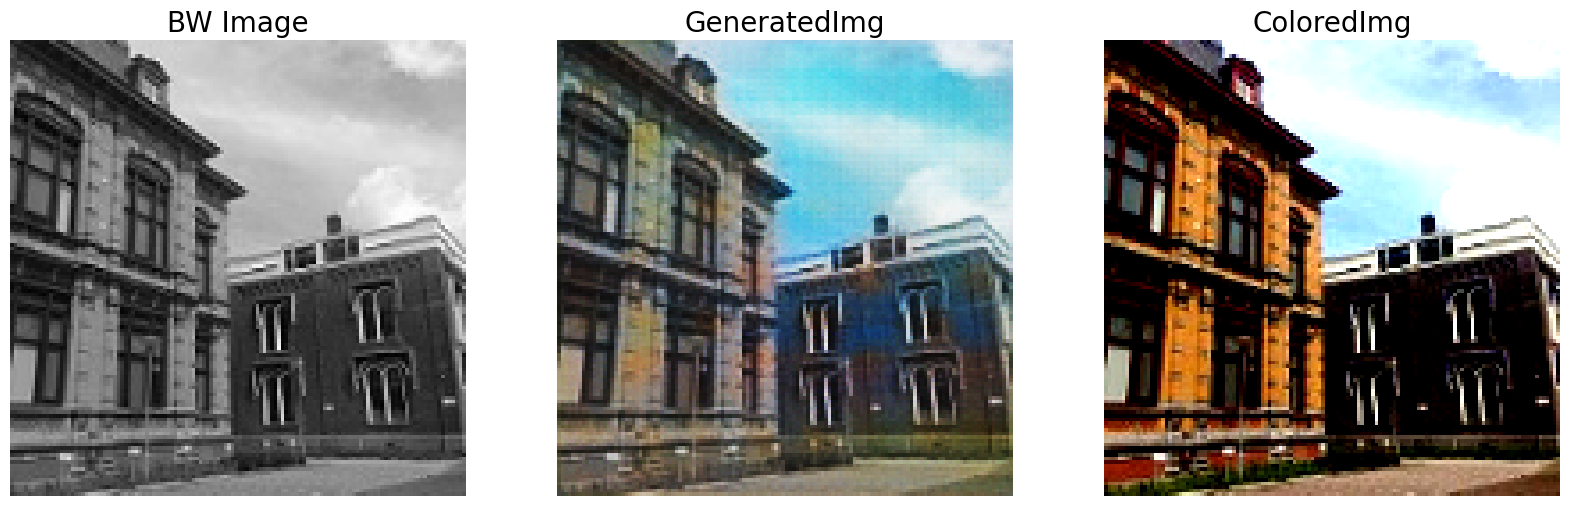

In [31]:
fit(epochs=10)

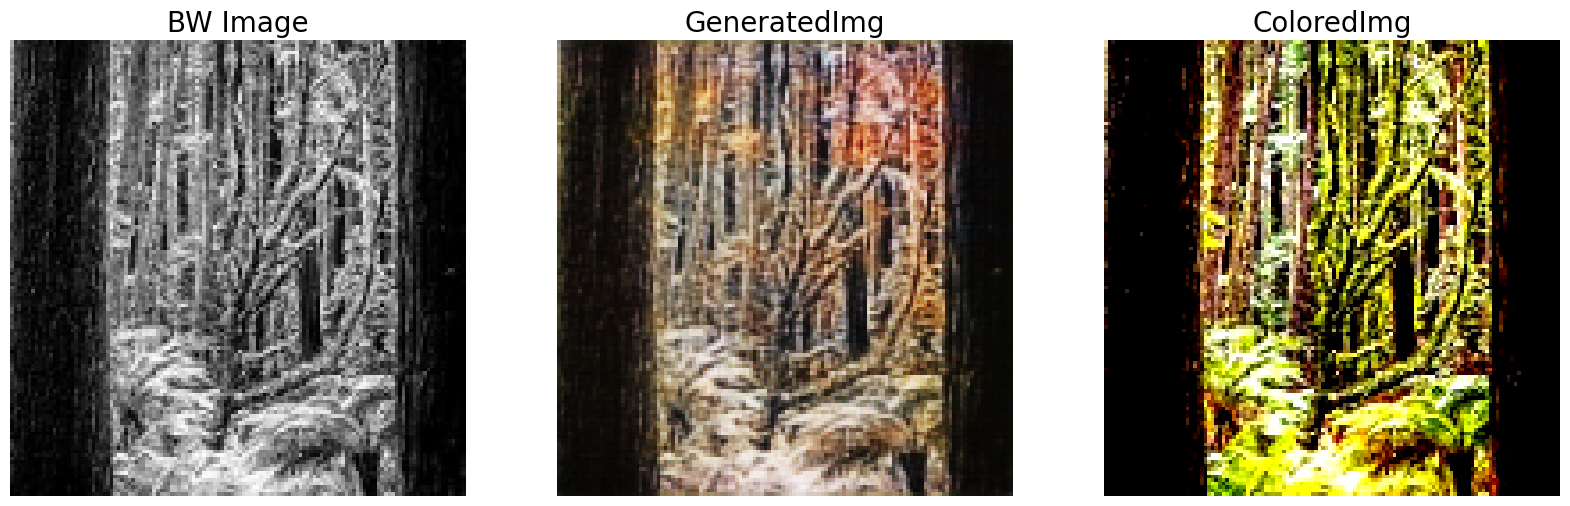

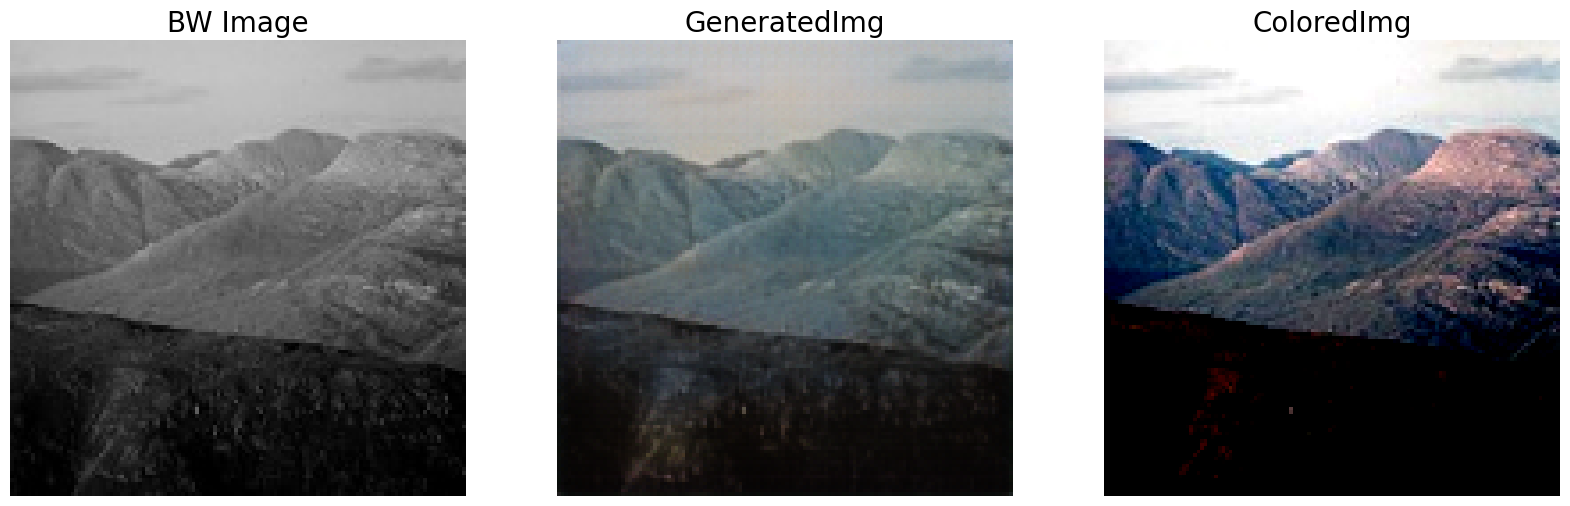

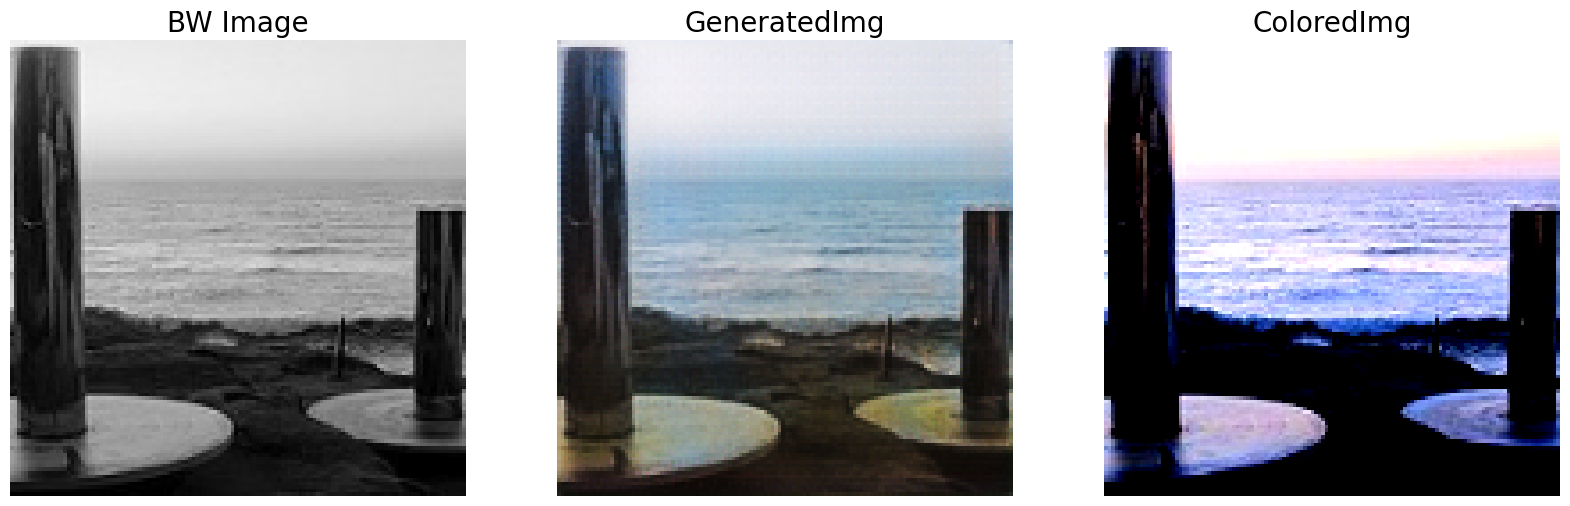

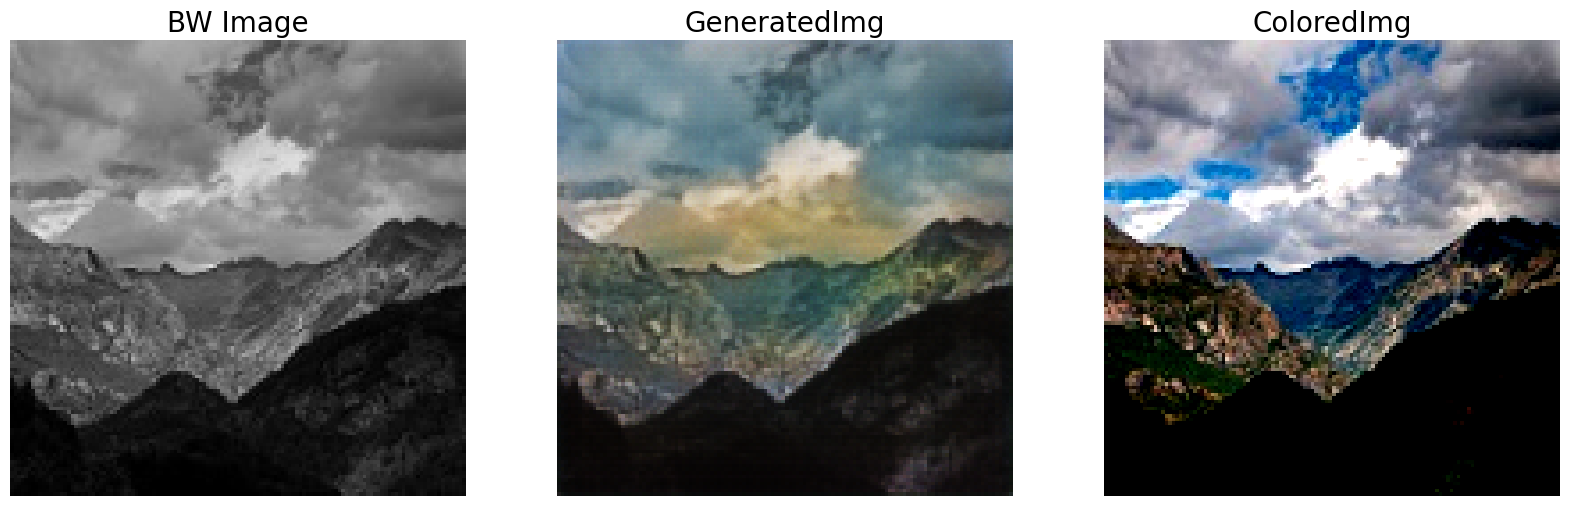

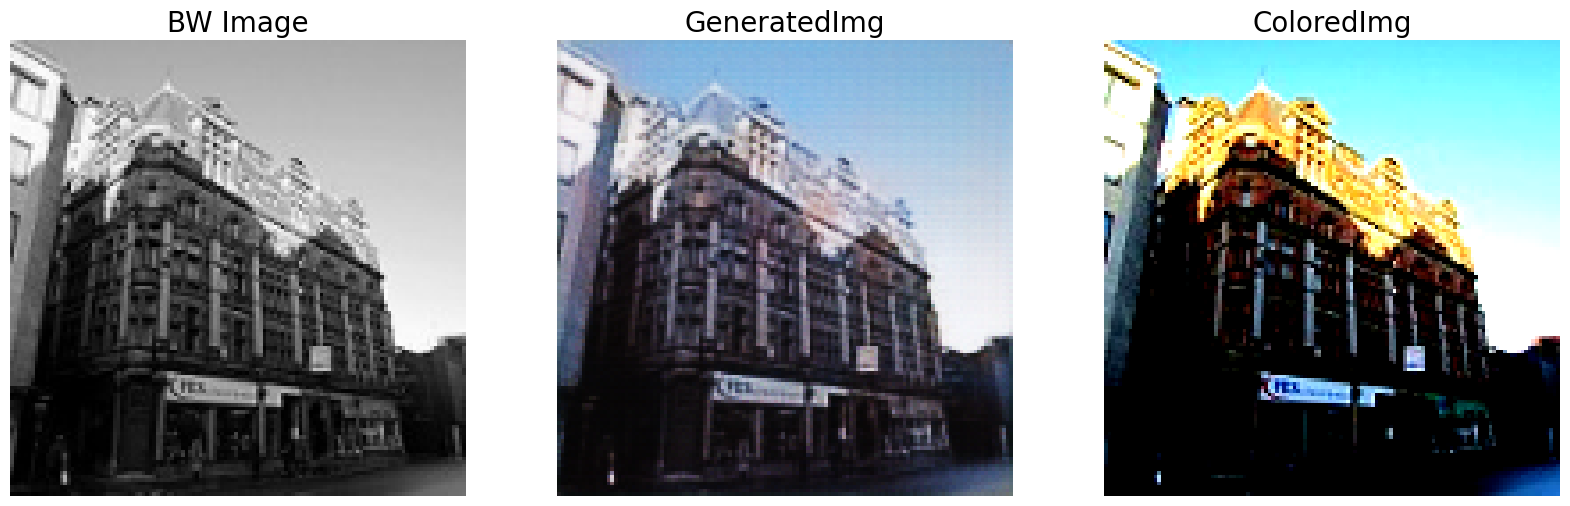

In [32]:
#Model Prediction:
for bwImage, tarImage in testDataset.take(5):
    genImage = generator(bwImage,training=True)
    fig(bwImage,genImage,tarImage)